In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in the Data

In [ ]:
import pandas as pd
import glob
import os
import numpy as np

# Full NCAA Dataset - 48 sec
df = pd.read_csv("/content/drive/MyDrive/USC Baseball/Datasets/Updated22_23_NCAA_Dataset.csv")

<ipython-input-2-7e143f33715e>:7: DtypeWarning: Columns (27,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/USC Baseball/Datasets/Updated22_23_NCAA_Dataset.csv")


# Clean up the data + Create Buckets


In [ ]:
#This will ignore all DeprecationWarning warnings in your code.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
cleandf = df[df['TaggedPitchType'].str.contains("Undefined|Other|,") == False]
cleanD1 = cleandf[cleandf['Level'] == "D1"]

In [ ]:
cleanConf = cleanD1[cleanD1['League'].isin(["SEC", "BIG12", "BIG10", "ACC", "PAC12", "CUSA", "SBELT", "AMER"])]

In [ ]:
# Reclassifies pitch type buckets
conditions = [
    (cleanConf['TaggedPitchType'].str.contains('Fastball|FourSeamFastBall|TwoSeamFastBall|OneSeamFastBall|Sinker')),  # Fastballs
    (cleanConf['TaggedPitchType'].str.contains('Slider|Cutter|Curveball')),  # Breaking Balls
    (cleanConf['TaggedPitchType'].str.contains('ChangeUp|Splitter|Knuckleball')),  # Offspeed
]

# creates a list of values
values = [1, 2, 3]
# creates new column determining hit or not and assign values to it based on the conditions
cleanConf['PitchBucket'] = np.select(conditions, values, default = 4)

<ipython-input-6-7b1c0ce79f90>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanConf['PitchBucket'] = np.select(conditions, values, default = 4)


In [ ]:
cleanConf['PitchBucket'].value_counts()

,count
PitchBucket,
1,1001439
2,576786
3,213075


In [ ]:
# Recodes Pitch Handedness to binary variable

conditions = [
    (cleanConf['PitcherThrows'] == 'Right'),  # RHP
    (cleanConf['PitcherThrows'] == 'Left')  # LHP
]

# creates a list of values to assign for pitch handedness where RHP = 1 & LHP = 0
values = [0, 1]
# creates new column determining pitch hand
cleanConf['PitcherHand'] = np.select(conditions, values)

<ipython-input-8-783810b04da9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanConf['PitcherHand'] = np.select(conditions, values)


In [ ]:
cleanConf['PitcherHand'].value_counts()

,count
PitcherHand,
0,1290893
1,500407


In [ ]:
conditions = [
    (cleanConf['PlayResult'] == 'Out'),  # Out
    (cleanConf['PlayResult'] == 'Error'),  # Walk
    (cleanConf['PlayResult'] == 'Single'),
    (cleanConf['PlayResult'] == 'Double'),
    (cleanConf['PlayResult'] == 'Triple'),
    (cleanConf['PlayResult'] == 'HomeRun'),
]

# creates a list of values to assign for pitch handedness where RHP = 1 & LHP = 0
values = [0, 0, 1, 2, 3, 4]
# creates new column determining pitch hand
cleanConf['hitResult'] = np.select(conditions, values, default = -1)

<ipython-input-10-2574b5b2495a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanConf['hitResult'] = np.select(conditions, values, default = -1)


In [ ]:
cleanConf['hitResult'].value_counts()

,count
hitResult,
-1,1506947
0,177538
1,69295
2,20881
4,14503
3,2136


In [ ]:
filteredDF = cleanConf[cleanConf['hitResult'] != -1].reset_index()

In [ ]:
print("Dataset size: " + str(len(filteredDF)))

Dataset size: 284353


# Making the model

In [ ]:
finalCleanDF = filteredDF.dropna(subset=['hitResult', 'PitcherHand', 'RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'SpinAxis', 'RelHeight', 'Extension', 'ExitSpeed', 'Angle'])
finalDF = finalCleanDF[['hitResult', 'PitcherHand', 'RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'SpinAxis', 'RelHeight', 'Extension', 'ExitSpeed', 'Angle']]

## Making Model

In [ ]:
out_class = finalDF[finalDF['hitResult'] == 0]
single_class = finalDF[finalDF['hitResult'] == 1]
double_class = finalDF[finalDF['hitResult'] == 2]
triple_class = finalDF[finalDF['hitResult'] == 3]
hr_class = finalDF[finalDF['hitResult'] == 4]

In [ ]:
print(len(out_class)/(len(out_class)+len(single_class)+len(double_class)+len(triple_class)+len(hr_class)))
print(len(single_class)/(len(out_class)+len(single_class)+len(double_class)+len(triple_class)+len(hr_class)))
print(len(double_class)/(len(out_class)+len(single_class)+len(double_class)+len(triple_class)+len(hr_class)))
print(len(triple_class)/(len(out_class)+len(single_class)+len(double_class)+len(triple_class)+len(hr_class)))
print(len(hr_class)/(len(out_class)+len(single_class)+len(double_class)+len(triple_class)+len(hr_class)))

0.6161788910119375
0.24451465218789611
0.07719026088272574
0.007904046614578407
0.054212149302862334


In [ ]:
# resamples the class
from sklearn.utils import resample
out_class_downsampled = resample(out_class,
                                      replace=False,  # sample without replacement
                                      n_samples=int(len(out_class)/1.5),  # match minority class size
                                      #n_samples = 390000,
                                      random_state=42)  # reproducible results
double_class_upsampled = resample(double_class,
                                      replace=True,  # sample without replacement
                                      n_samples=int(len(double_class)*1.3),  # match minority class size
                                      #n_samples = 390000,
                                      random_state=42)  # reproducible results
triple_class_upsampled = resample(triple_class,
                                      replace=True,  # sample without replacement
                                      n_samples=int(len(triple_class)*1.5),  # match minority class size
                                      #n_samples = 390000,
                                      random_state=42)  # reproducible results
hr_class_upsampled = resample(hr_class,
                                      replace=True,  # sample without replacement
                                      n_samples=int(len(hr_class)*1.3),  # match minority class size
                                      #n_samples = 390000,
                                      random_state=42)  # reproducible results

# Combine minority class and downsampled majority class
balanced_df = pd.concat([out_class_downsampled, single_class, double_class_upsampled, triple_class_upsampled, hr_class_upsampled])




In [ ]:
# Shuffle the data to avoid order effects
# figure why this don't work
balanced_df = balanced_df.sample(frac=1, random_state=42)


In [ ]:
rel_data = balanced_df[['hitResult', 'PitcherHand', 'RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'SpinAxis', 'RelHeight', 'Extension','ExitSpeed', 'Angle' ]].to_numpy()


classification = balanced_df['hitResult'].to_numpy()

In [ ]:
balanced_df['hitResult'].value_counts()

,count
hitResult,
0,108568
1,64624
2,26521
4,18626
3,3133


In [ ]:
sampledTotal = len(balanced_df)
print("total is: " + str(sampledTotal))
trainTotal = int(0.8*sampledTotal)

total is: 221472


In [ ]:
# Split data into features and target
X = balanced_df.drop(['hitResult'], axis=1)
y = balanced_df['hitResult']

# Split data into training and testing sets
x_train = X[:trainTotal]
x_test = X[trainTotal:]
y_train = y[:trainTotal]
y_test = y[trainTotal:]

# from sklearn import preprocessing

# # Standardize the features
# scaler = preprocessing.StandardScaler().fit(x_train)
# x_train_scaled = scaler.transform(x_train)
# x_test_scaled = scaler.transform(x_test)

### Making XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert the dataset into DMatrix for XGBoost
train_data = xgb.DMatrix(x_train, label=y_train)
test_data = xgb.DMatrix(x_test, label=y_test)

# Define XGBoost parameters for multi-class classification
params = {
    'objective': 'multi:softprob',  # Softmax for multi-class classification
    'num_class': len(y.unique()),  # Number of classes in the target variable
    'max_depth': 4,                # Maximum depth of a tree
    'eta': 0.01,                    # Learning rate
    'n_estimators': 115,
    'subsample': 0.8,              # Subsample ratio of the training data
    'colsample_bytree': 0.8,       # Subsample ratio of columns
    'eval_metric': 'mlogloss'      # Evaluation metric
}

In [ ]:
# Train the model
model = xgb.train(params, train_data, num_boost_round=100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Make predictions on the test set
y_pred_probs = model.predict(test_data)

In [ ]:
if params['objective'] == 'multi:softprob':
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get the index of the highest probability for each instance
else:
    y_pred = y_pred_probs  # For 'multi:softmax', the prediction is already in label format


In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 49.19%


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display accuracy for each class
for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy * 100:.2f}%")

Accuracy for class 0: 100.00%
Accuracy for class 1: 0.00%
Accuracy for class 2: 0.00%
Accuracy for class 3: 0.00%
Accuracy for class 4: 0.00%


### Making Hit Type Classification Model

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
# !pip install -U xgboost

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost"
]

classifiers = [
    # DecisionTreeClassifier(max_depth=50),
    #DecisionTreeClassifier(max_depth=5),
    # RandomForestClassifier(max_depth=None, n_estimators=145)
    XGBClassifier(device='gpu', eta=0.01, max_depth=100, n_estimators=150, use_label_encoder=False, eval_metric='logloss')
]

In [ ]:
accuracies = []
for opt in classifiers:
  clf = make_pipeline(StandardScaler(), opt)
  clf.fit(x_train, y_train)

  y_pred = clf.predict((x_test))
  accuracies.append(metrics.accuracy_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:04:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import classification_report
# target_names = ['not Whiff, yes Whiff']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     21786
           1       0.67      0.67      0.67     12922
           2       0.80      0.70      0.74      5230
           3       0.95      0.58      0.72       629
           4       0.81      0.88      0.85      3728

    accuracy                           0.75     44295
   macro avg       0.80      0.72      0.75     44295
weighted avg       0.75      0.75      0.75     44295



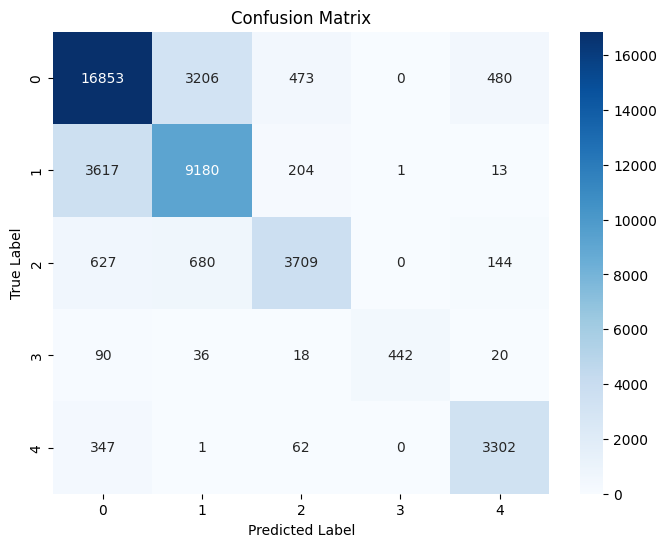

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


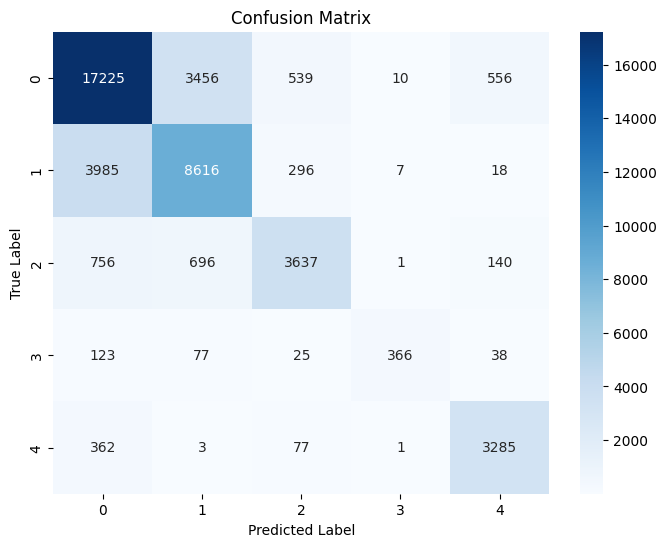

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(accuracies)

[0.7697046316515344]


In [ ]:
print(accuracies)

[0.7479173721639011]


### Export Hit Type Classification Model

In [ ]:
import joblib
from joblib import dump

import os
os.chdir('/content/drive/Shareddrives/USC Baseball/ML Stuff/Pitcher xwOBACON/Model')

# export the trained model to disk
joblib.dump(clf, 'HitTypeClassificationModel.joblib')

['HitTypeClassificationModel.joblib']